In [1]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input 
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D, Flatten
from tensorflow.keras.models import Model

In [2]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, kernel_size=(1,1), padding='same', activation='relu')(x)
    
    preconv_3x3 = Conv2D(filters_3x3_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, kernel_size=(3,3), padding='same', activation='relu')(preconv_3x3)
    
    preconv_5x5 = Conv2D(filters_5x5_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, kernel_size=(5,5), padding='same', activation='relu')(preconv_5x5)
    
    pool_proj = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, kernel_size=(1,1), padding='same', activation='relu')(pool_proj)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

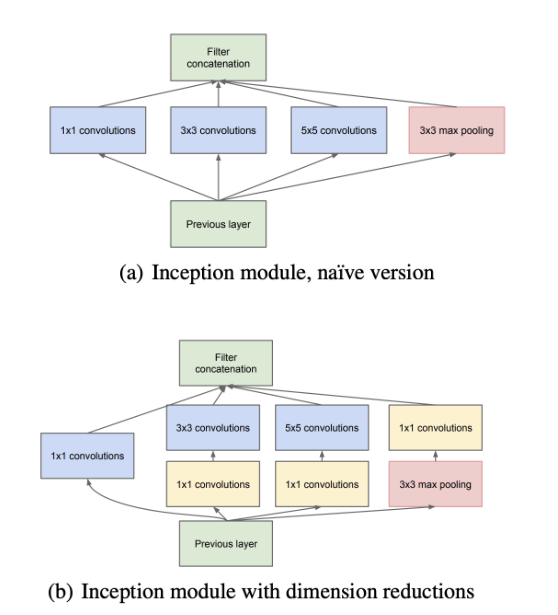

In [3]:
def residual_block(x, kernel_size, filters, s=2):
    f1,f2,f3 = filters
    x_shortcut = x
    
    # Shortcut Path
    x_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(s,s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    # Main Path
    # First Component
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Component
    x = Conv2D(f2, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third Component
    x = Conv2D(f3, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x


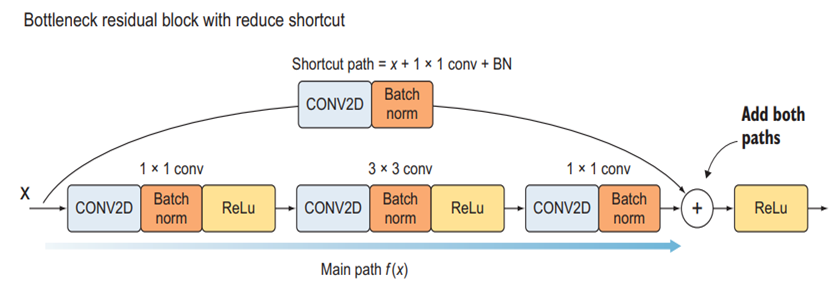

In [4]:
def mobilenet_block(x, kernel_size, filters, strides):
    x = DepthwiseConv2D(kernel_size=(kernel_size,kernel_size), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size=(1,1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


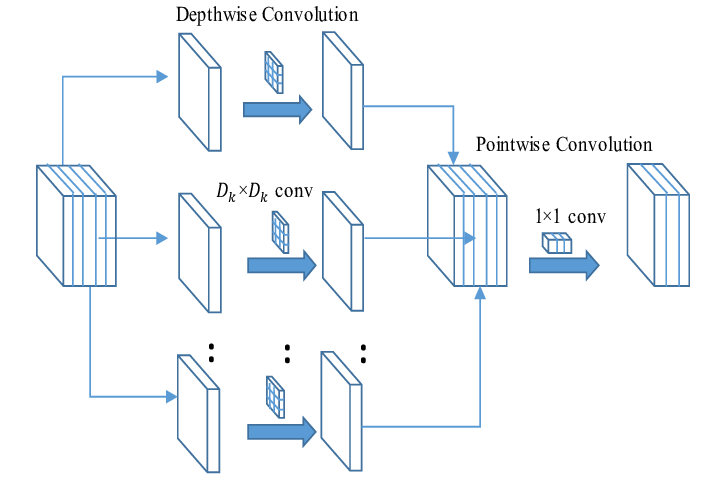

QS 1

In [5]:
input_layer = Input(shape = (224, 224, 3))

x = Conv2D(32, kernel_size = (11, 11), strides = (2, 2), padding = 'same', activation = 'relu')(input_layer)
x = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x)

x = inception_module(x, 64, 96, 128, 16, 32, 32, name = 'inception_1')
x = inception_module(x, 364, 192, 364, 48, 128, 128, name = 'inception_2')

x = GlobalAveragePooling2D()(x)
output = Dense(10, activation = 'softmax')(x)

model = Model(inputs = input_layer, outputs = output)


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  11648       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 32)   0           ['conv2d[0][0]']                 
                                                                                              

QS 2

In [7]:
input_layer = Input(shape = (227, 227, 3))

x = Conv2D(32, kernel_size = (7, 7), strides = (1, 1), padding = 'same', activation = 'relu')(input_layer)
x = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x)

x = inception_module(x, 64, 96, 128, 16, 32, 32, name = 'inception_1')
x = inception_module(x, 64, 96, 128, 16, 32, 32, name = 'inception_2')

x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)

x = Flatten()(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(512, activation = "relu")(x)
output = Dense(10, activation = "softmax")(x)

model = Model(inputs = input_layer, outputs = output)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 227, 227, 32  4736        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 114, 114, 32  0          ['conv2d_13[0][0]']              
                                )                                                           

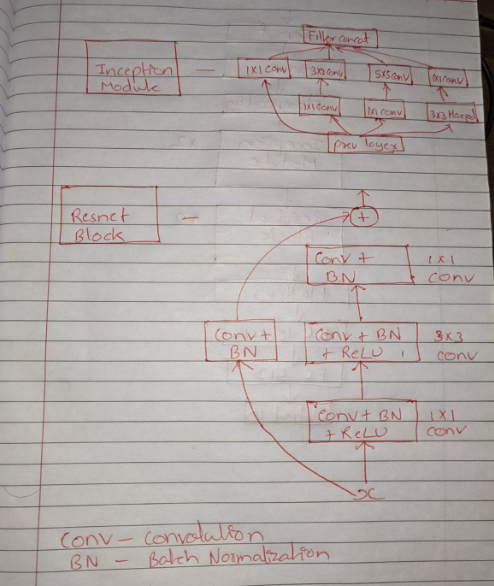

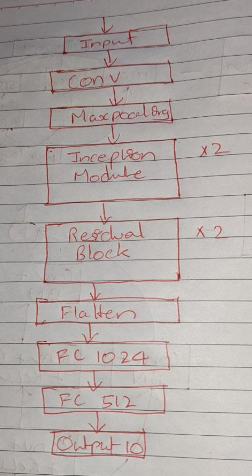

QS 3

In [9]:
input_layer = Input(shape = (227, 227, 3))

x = Conv2D(32, kernel_size = (7, 7), strides = (1, 1), padding = 'same', activation = 'relu')(input_layer)
x = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')(x)

x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)

x = inception_module(x, 64, 96, 128, 16, 32, 32, name = 'inception_1')
x = inception_module(x, 64, 96, 128, 16, 32, 32, name = 'inception_2')

x = Flatten()(x)
x = Dense(512, activation = "relu")(x)
x = Dense(1024, activation = "relu")(x)
output = Dense(10, activation = "softmax")(x)

model = Model(inputs = input_layer, outputs = output)

In [10]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 227, 227, 32  4736        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 114, 114, 32  0          ['conv2d_34[0][0]']              
                                )                                                           

QS 4

In [12]:
input_layer = Input(shape = (227, 227, 3))

x = Conv2D(32, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = mobilenet_block(x, 3, 64, 1)
x = mobilenet_block(x, 3, 64, 1)


x = inception_module(x, 160, 112, 224, 24, 64, 64, name = 'inception_1')
x = inception_module(x, 128, 128, 256, 24, 64, 64, name = 'inception_2')

aux_avg = GlobalAveragePooling2D()(x)
aux_dropout = Dropout(0.4)(aux_avg)
aux_output = Dense(10, activation = 'softmax')(aux_dropout)

x = inception_module(x, 256, 160, 320, 32, 128, 128, name = 'inception_3')
x = inception_module(x, 384, 192, 384, 48, 128, 128, name = 'inception_4')

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs= input_layer, outputs=[aux_output,output])

In [13]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_82 (Conv2D)             (None, 114, 114, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 114, 114, 32  128        ['conv2d_82[0][0]']              
 ormalization)                  )                                                           

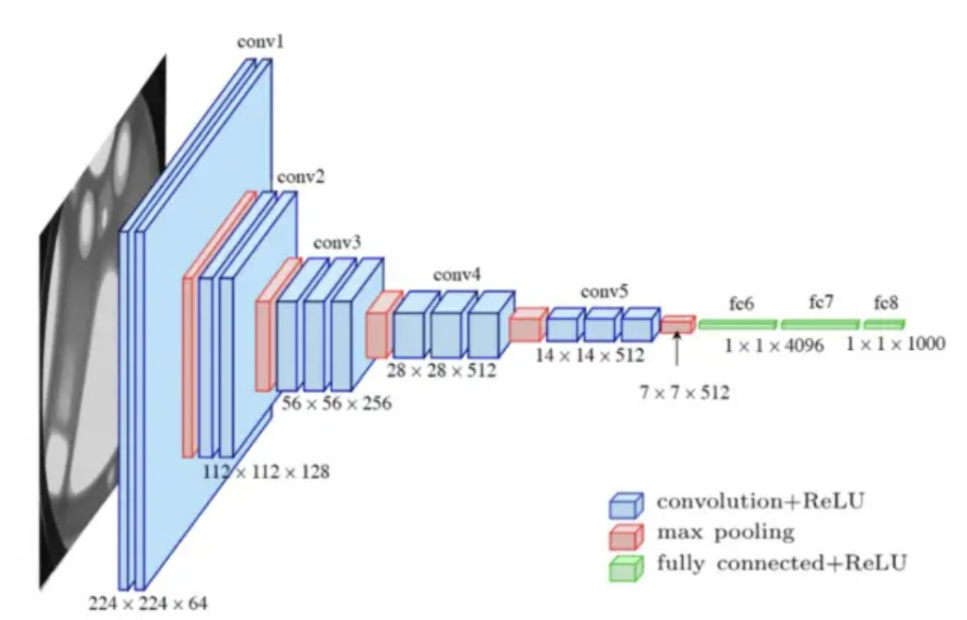
